In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from CP1.linkage_utils import *

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

# deteministic random numbers
np.random.seed(0)
random.seed(0)

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


# Linkage Synthesis Challenge Problem

In this challenge problem you are tasked with synthesizing planar linkage mechanisms to trace six different output shapes. Further, you are tasked with synthesizing mechanisms such that the total material used for the mechanisms in minimized.

<img src="https://i.ibb.co/PDK5pFK/Cartoon-Blob-Stock-Illustrations-14-476-Cartoon-Blob-Stock-Illustrations-Vectors-Clipart-Dreamstime.png" width="100%" style="max-width: 600px; display:block; margin:auto;">


Our six blob friends have a big problem—they really want drawings of themselves, but as you can see, they don’t have hands! Every time they try to create a self-portrait, it’s a disaster of wobbly lines and curves. That’s where your optimization skills come in. Your job is to design mechanical linkages that can trace the outline of each blob, helping them finally get accurate portraits of themselves. They’re relying on you to make sure their outlines are captured perfectly, down to the last curve. Unfortunately, our blobs don’t have much in the way of money. So, in addition to accuracy, they need you to minimize material usage. Your mechanism should be as efficient as possible, using the least amount of material to get the job done.

We have given you the outlines they want of themselves in a numpy file called `target_curves.npy` which you can load using numpy and plot using matplotlib:

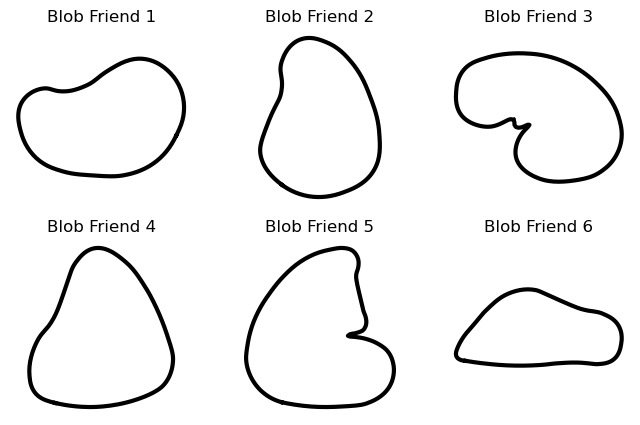

In [3]:
target_curves = np.load('target_curves.npy')

# Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(8, 5))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].plot(x_coords, y_coords, color='black', linewidth=3)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Blob Friend {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')
    axs[i // 3, i % 3].axis('off')


<font color="red" size="8"><b>WARNING: </b></font> If you plan to work on this notebook in colab we would like to warn you that if you do not download any files you save or save the changes separately, upon the runtime being killed either by you closing the tab/browser or by timing out due to inactivity you WILL LOSE YOUR FILES AND WORK. It is highly recommeneded that you make a local python environment to work.

## Overview
The first portion of this notebook will help you understand the linkage design problem and the way we parameterize each linkage design. It will also discuss deliverables and submission instructions. In the second half of this notebook we provide you with a working implementation that you can use as a baseline. **IMPORTANT:** We also provide numerous helper functions in the linkage_utils. We touch on most of these functions in this notebook but some *very useful* functions will be covered in the advanced notebook!

### Project Files and Functions Provided:

All files as well as helper functions and further information can be found in the Github repository of this challenge problem:
[Github Repo](https://github.com/ahnobari/2155-Challenge-Problem-1)

### Mechanism Representation

For this project, we represent planar mechanisms using the following components:
<ol>
    <li><b>Adjacency/Connectivity Matrix: </b>A linkage mechanisms structure can be represented using a matrix of connectivity (C), which is similar to the adjacency matrix in graphs (networks). The connectivity matrix for a mechanisms with $N$ nodes is a symmetric $N\times N$ matrix with each row and column representing each node and its connections to other nodes. Take the example below:

<img src="https://transportgeography.org/wp-content/uploads/simple_connectivity_matrix2.png" width="100%" style="max-width: 700px; display:block; margin:auto;" alt="Connectivity Matrix">

For Node A we use the first row/column of the matrix and we see that A is connected to B (which is represented by the second row/column). To represent this connection in the connectivity matrix we will set the value of the $(1,2)$ and $(2,1)$ elements of the matrix to be 1. Similarly any time any nodes $i$ and $j$ are connected we set the value of the $(i,j)$ and $(j,i)$ elements to be 1 and 0 if the nodes are not connected.</li>
    <li><b>Node Types: </b>To define the mechanism we must also know which nodes are fixed (or ground nodes). For this purpose we store the list of  ground nodes' numbers.</li>
    <li><b>Motor: </b>To simulate the kinematics of the mechanism we also need to know which linkage is driven (i.e., has the motor attached to it). For this purpose we store the numbers of the two nodes that the driven linkage is connected to.</li>
    <li><b>Initial Positions: </b>Finally, we need to know the initial positions of the nodes that make up the mechanism. For this we store the $x,y$ positions of the nodes in a list. Note that all node positions must be floating point numbers between 0 and 1 (i.e., The initial positions of the mechanism must fit into a box of 1x1).</li>
</ol>

#### Example:
Take the following mechanism (Note that node numbers are started from 0 in our representation):

<img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" width="100%" style="max-width: 500px; display:block; margin:auto;" alt="Numbered Mechanism">

For this example mechanism we have the following Connectivity Matrix (<code>C</code>), initial positions matrix (<code>x0</code>), motor linkage (<code>motor</code>), and a list of fixed nodes(<code>fixed_nodes</code>):

In [4]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.55],
               [0.6,0.63],
               [0.5,0.7]])

# Motor
# Note: motor[0] is the driving node and motor[2] is being driven around Motor[0]
motor = np.array([0,2])

**Drawing mechanisms:** To visualize this in python we have provided the <code>draw_mechanism(C,x0,fixed_nodes,motor)</code> function to you in the <code>linkage_utils</code> module.

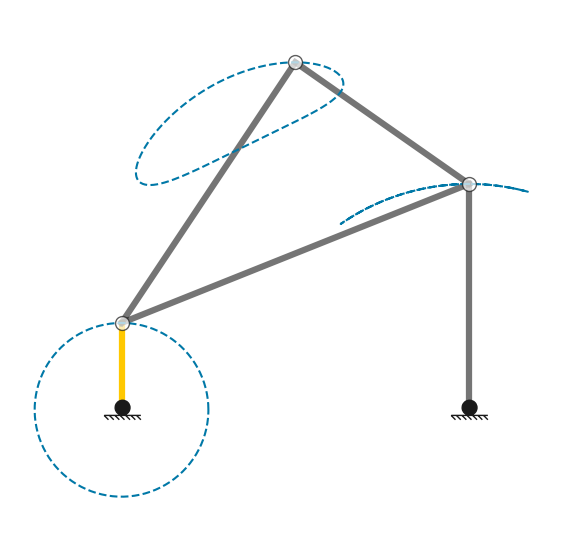

In [5]:
# Set the Figure Size
plt.figure(figsize=(7,7))

# Plot Mechanism
draw_mechanism(C,x0,fixed_nodes,motor)

### Instructions

The target curves are provided to you as a sequence of points. The curves your mechanisms generate are re-oriented then compared to the target curves: We measure the closeness of two point curves by computing the bi-directional chamfer distance between the two point clouds.

The other objective in this challenge problem is reducing the material used by the mechanism. This is the total length of all links in the mechanism. We have provided a function that makes this measurement for you using initial positions and adjacency matrix for a mechanism (The functions and useful tools are going to be described later).

[IMPORTANT] In this project three constraints are set for you:
<ul>
    <li><b>Chamfer Distance: </b>Any mechanisms output with a chamfer distance to the target curve larger than 0.1 will be considered invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Material Use: </b>Any mechanism with total linkage lengths more than 10.0 will be deemed invalid and will not be used to calculate the score of the submissions.</li>
    <li><b>Mechanism Complexity: </b>For this project we want you to generate mechanisms with no more than 20 nodes (i.e., <code>N<=20</code>).</li>
</ul>

Submitted mechanisms that violate these constraints will not be scored.

Your performance on the targets will be measured based on the hypervolume calculated from the population with a reference point of 0.1 for chamfer distance and 10.0 for material use. Note that we limit the number of mechanisms you are permitted to submit as potential solutions for any given curve to 1000. The closer you get to ideal the higher the score you will receive. The total score for your submission will be the average hypervolume for all target curves.

## Starter Code: Setting up Multi-Objective Optimization With Constraints Using Pymoo

Now that we have established the details to the project lets set up the problem in Pymoo and run an example. Here we will also discuss how your submissions are going to be evaluated to get your final score. Before that, we will introduce a possible approaches for solving this problem. We will use a GA optimizer availabe through the pymoo package. This approach will be a simple approach to only optimize the positions of a given mechanism (We provide this) and the more comprehensive aproach will be one of allowing the GA to generate the full structure of mechanisms which is discussed in the advanced notebook and not here.

For this simple approach of using a sepcific mechanism skeleton we have provided a base mechanism in a numpy file called `starter_mechanism.npy`:

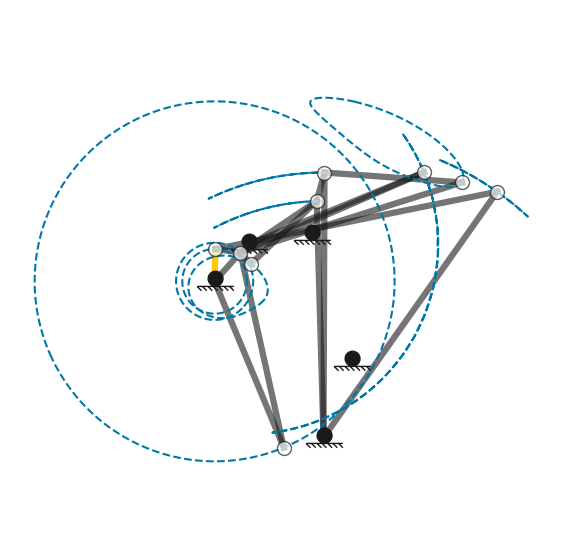

In [7]:
# load the starter mechanism
starter_mech = np.load('starter_mechanism.npy',allow_pickle=True).item() #Load mechanism
C,x0,fixed_nodes,motor = starter_mech['C'],starter_mech['x0'],starter_mech['fixed_nodes'],starter_mech['motor'] #Extract variables

plt.figure(figsize=(7,7))
draw_mechanism(C,x0,fixed_nodes,motor) #Draws mechanism

Now we will use an approach similar to the demo to define our problem. Note that here we will also add consraints to the problem to remove unacceptable mechanisms (Chamfer distance above 0.1 and material more than 10.0):

In [8]:
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self,C,fixed_nodes,motor,target_curve):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = C.shape[0] * 2, n_obj=2, n_constr=2, xl=0.0, xu=5.0)

        # Store mechanism information for later
        self.C = C
        self.fixed_nodes = fixed_nodes
        self.motor = motor
        self.N = C.shape[0]

        # Store the target curve
        self.tpc = target_curve


    def convert_1D_to_mech(self, x):
        # This function outputs a mechanisms given a 1D representation of positions
        N = self.N

        C = self.C
        fixed_nodes = self.fixed_nodes
        motor = self.motor
        target = C.shape[0]-1
        x0 = x.reshape([N,2])

        return target, C, x0, fixed_nodes, motor

    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        valid, CD, mat, _, _ = evaluate_mechanism(self.C,x0,self.fixed_nodes, self.motor, self.tpc, idx=None,device='cpu',timesteps=2000)
        
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf, np.Inf]
        else:
            out["F"] = [CD,mat]

            # Set constraints as CD<=0.5 and Material<=6.0
            # Be careful about modifying these - designs that
            # violate the problem constraints will not be scored.
            out["G"] = [CD - 0.1, mat - 10.0]

Now we will run NSGA-II on this problem. Note that the code below replaces the sampling of the algorithm with the initial positions of the pre-defined mechanism. This is an example of population initialization. Becuase this mechanism skeleton is bigger the GA usually struggles to find any valid solutions so this will help start with a better population. This will be discussed in more detail in the advanced notebook. For now let's run this on the first curve:

(-0.2373162917792797,
 0.22283070906996727,
 -0.15672720298171045,
 0.16977279707789422)

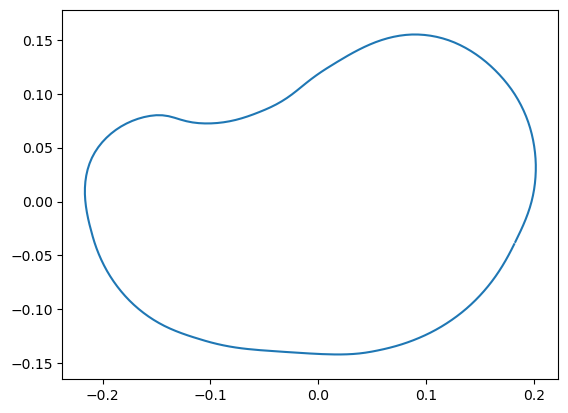

In [9]:
# Get target curve 0 and plot
target_index = 0
target_curve = np.array(target_curves[target_index])
plt.plot(target_curve[:,0],target_curve[:,1])
plt.axis('equal')

In [10]:
problem = mechanism_synthesis_optimization(C,fixed_nodes,motor,target_curve)

# Initialize a population of duplicates
X = x0[None].repeat(100, axis=0).reshape(100, -1)

# Setup the algorithm
algorithm = NSGA2(pop_size=100,
                    sampling=X,
                    crossover=SBX(prob=1.0, eta=3.0),
                    mutation=PolynomialMutation(eta=3.0, prob=0.05),
                    eliminate_duplicates=True)

results = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   verbose=True,
                   save_history=True,
                   seed=0,
                  )

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |        1 |      1 |  4.2078836188 |  4.2078836188 |             - |             -
     2 |       98 |      1 |  2.3678703770 |           INF |             - |             -
     3 |      198 |      1 |  2.3678703770 |  5.1114422464 |             - |             -
     4 |      298 |      1 |  2.3678703770 |  4.0078831152 |             - |             -
     5 |      398 |      1 |  2.3678703770 |  3.7066872928 |             - |             -
     6 |      498 |      1 |  1.2529190645 |  3.1792494633 |             - |             -
     7 |      598 |      1 |  1.2529190645 |  2.6156662913 |             - |             -
     8 |      698 |      1 |  1.2496927842 |  2.1846786415 |             - |             -
     9 |      798 |      1 |  0.1502416059 |  1.8273383387 |             - |             -
    10 |      898 |      1 |  0.000000E+00 |  1.3763018673 |             - |             -

Pymoo automatically saves the optimal set of solutions and their corresponding performance. <code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions. The constraints that we specify in the problem guidelines are used as a reference point for hypervolume calculations which we will use to measure your submissions performance. Lets visualize one of the solutions.

Hyper Volume ~ 0.174295


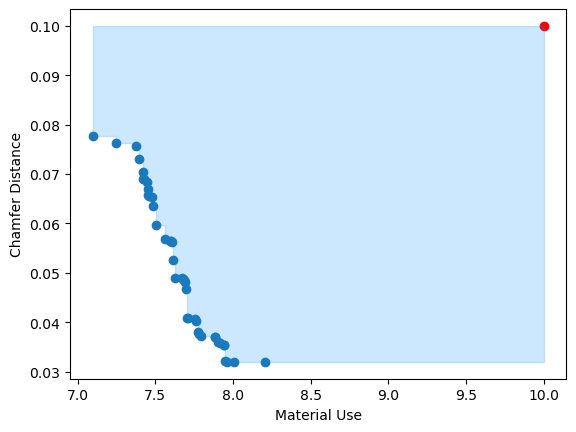

In [11]:
from pymoo.indicators.hv import HV

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.1, 10.0])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    plot_HV(results.F, ref_point) #use the plot_HV function from utils
else:
    print('Did Not Find Solutions!!')

Now lets plot the results for the best chamfer distance solution

In [12]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,0])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

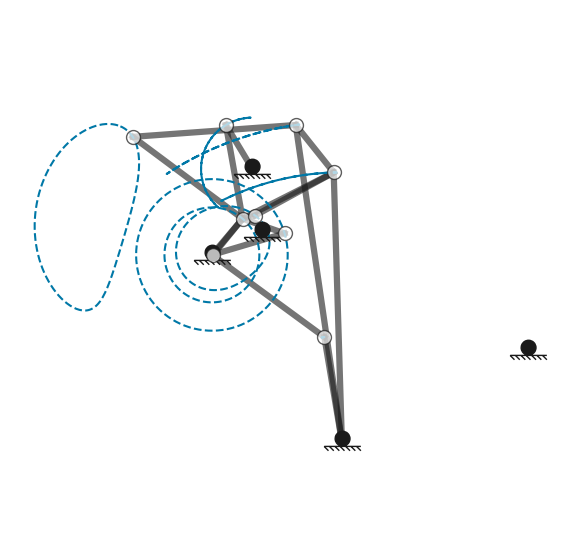

In [13]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)
    # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
    # Step 2: Draw
    plt.figure(figsize=(7,7))
    draw_mechanism(C,x0,fixed_nodes,motor) #use the draw_mechanism function from utils

else:
    print('Did Not Find Solutions!!')

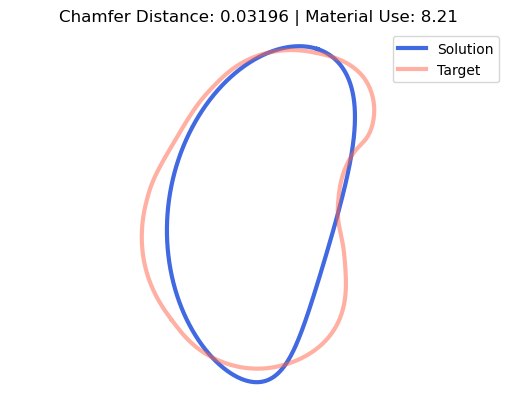

In [14]:
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve) #use the comparecurves function from utils
else:
    print('Did Not Find Solutions!!')


Now lets see the solution with the least material use

In [15]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,1])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

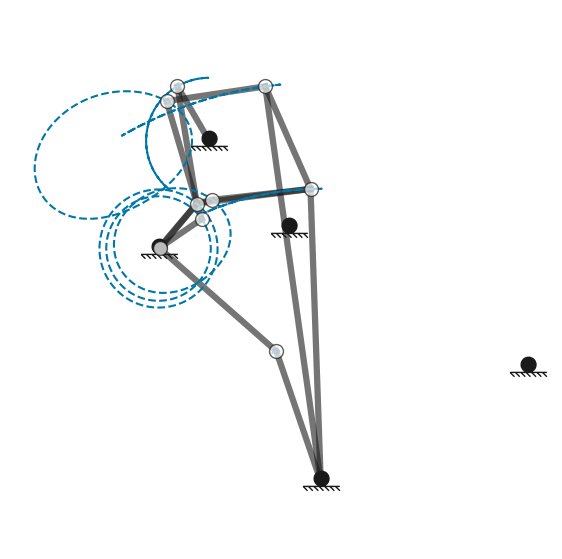

In [16]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)

    # Step 2: Draw
    plt.figure(figsize=(7,7))
    draw_mechanism(C,x0,fixed_nodes,motor) #use the draw_mechanism function from utils
else:
    print('Did Not Find Solutions!!')

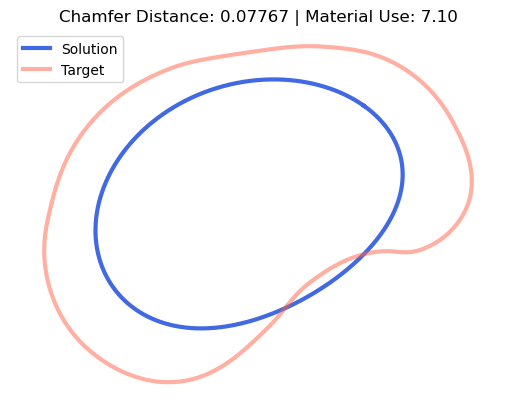

In [17]:
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve) #use the comparecurves function from utils
else:
    print('Did Not Find Solutions!!')

At this point you may like to save your mechanisms. Lets save our population for submission as a csv. To make this easier, we will reorganize the mechanism representation into a 1D vector. To make things easier we have provided the <code>to_final_representation(C,x0,fixed_nodes,motor,target)</code> function to you in the <code>linkage_utils module</code>. This function is named as such because the final submission will take these 1D vectors (more on this later). 

We have also provided a function <code>save_population_csv(file_name,population)</code> which will help you make the conversion from python array to .csv for all members of a population.

In [19]:
if not results.X is None:
    # First get generalized 1D representation
    mechanisms = []

    for x in results.pop.get("X"):
        target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
        mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target)) 
    save_population_csv('./results/%i.csv'%target_index,mechanisms) #use the save_population_csv function from utils
else:
    print('Did Not Find Solutions!!')

You can also use the provided <code>get_population_csv(file_name)</code> to load the list of mechanisms as from a .csv file. Let's reload the mechanisms and draw the first one to double-check. We also have provided the <code>from_1D_representation(mechanism)</code> function which returns <code>C,x0,fixed_nodes,motor,target</code> from the 1D representation, essentially reversing the process. As with the other helper functions, the code for this can be found in the provided utils file.

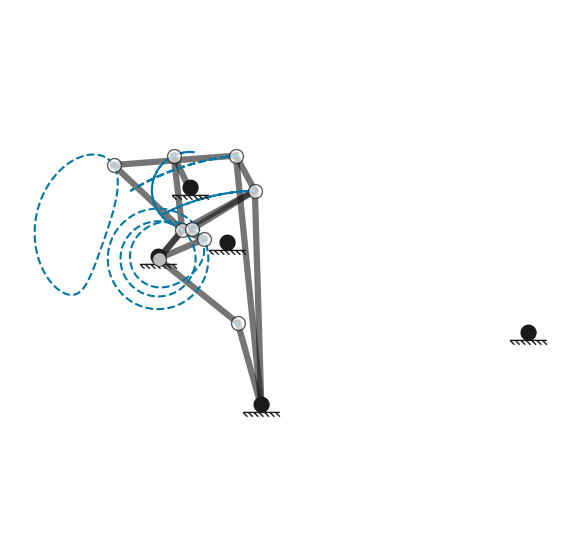

In [20]:
if os.path.exists('./results/%i.csv'%target_index):
    population_reloaded = get_population_csv('./results/%i.csv'%target_index) #use the get_population_csv function from utils
    C,x0,fixed_nodes,motor,target = from_1D_representation(population_reloaded[0]) 
    plt.figure(figsize=(7,7))
    draw_mechanism(C,x0,fixed_nodes,motor) #use the draw_mechanism function from utils
else:
    print('We never saved the results (probably because we did not find any)')

We can also visualize the design from the pareto front. This function takes in an array of many 1D mechanisms concatenated together.

In [ ]:
if not results.X is None:
    # Visualize pareto front using the visualize_pareto_front function from utils
    visualize_pareto_front(np.array(mechanisms),results.pop.get("F"),target_curve) 
else:
    print('Did Not Find Solutions!!')

### Now Let's Get a Submission Going

## Submission Format

You will submit a .csv file for each target curve, therefore you will have a total of 6 .csv files. We also ask that you submit the 6 .csv files as a zip file. The naming scheme for the submission will be #.csv where you replace # with the number of the target curve starting from 0.csv and up to 6.csv.

To get a score for a submission place all 6 .csv files for in the results folder. Then you can get your overall score by running the following function in the main directory:

In [21]:
evaluate_submission(target_curves_path = './target_curves.npy', results_folder = './results')

  0%|          | 0/6 [00:00<?, ?it/s]

Evaluating Curve 0 Solution
Score Break Down:
Curve 0: 0.174295
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.029049


0.029049202279664735

Alternatively you can run the following command in the terminal (loaded to the main directory of the repo):

In [22]:
!python evaluate.py

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.71it/s]
Score Break Down:
Curve 0: 0.174295
Curve 1: 0.000000
Curve 2: 0.000000
Curve 3: 0.000000
Curve 4: 0.000000
Curve 5: 0.000000
Overall Score: 0.029049


Since we have only come up with solutions for one curve, most of our scores are 0. Now lets run the process for all the target curves in a loop:

Hyper Volume ~ 0.347005
Hyper Volume ~ 0.439026
Hyper Volume ~ 0.408798
Hyper Volume ~ 0.371874
Hyper Volume ~ 0.345926
Hyper Volume ~ 0.533708
--- Execution time: 253.1463394165039 seconds ---


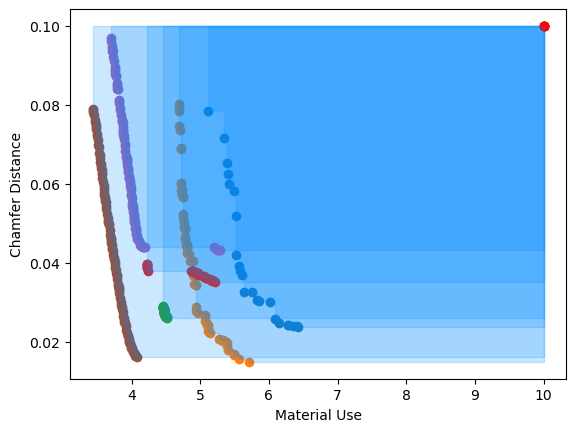

In [23]:
import time
start_time = time.time()

for i,target_curve in enumerate(target_curves): #Loop through all target curves
    # Setup Problem
    problem = mechanism_synthesis_optimization(C,fixed_nodes,motor,target_curve)

    # Initialize a population of duplicates
    X = x0[None].repeat(100, axis=0).reshape(100, -1)

    # Setup the algorithm
    algorithm = NSGA2(pop_size=100,
                        sampling=X,
                        crossover=SBX(prob=1.0, eta=3.0),
                        mutation=PolynomialMutation(eta=3.0, prob=0.05),
                        eliminate_duplicates=True)

    results = minimize(problem,
                        algorithm,
                        ('n_gen', 50),
                        verbose=True,
                        save_history=True,
                        seed=0,
                        display=best())

    if results.X is None:
        print('Did Not Find Solutions for any Seed!!')
    else:
        mechanisms = []
        for x in results.X:
            target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)

            #Call the function from utils to convert to final representation
            mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))

        ref_point = np.array([0.1, 10])
        ind = HV(ref_point)
        hypervolume = ind(results.F)
        print('Hyper Volume ~ %f' %(hypervolume))
        plot_HV(results.F, ref_point)

        save_population_csv('./results/%i.csv'%i,mechanisms)
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

Now let's see how we did:

In [24]:
!python evaluate.py

Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/johnson/mambaforge/envs/topology/lib/python3.10/site-packages/jax_plugins/xla_cuda12/__init__.py", line 78, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'
100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]
Score Break Down:
Curve 0: 0.347005
Curve 1: 0.439026
Curve 2: 0.408798
Curve 3: 0.371874
Curve 4: 0.345926
Curve 5: 0.533708
Overall Score: 0.407723


### Submitting to Leaderboard

Check out the live [Leaderboard](https://decode.mit.edu/CP1/) for the Challenge Problem. You may self-report your scores using this [Submission Form](https://docs.google.com/forms/d/e/1FAIpQLSfbkoTN1rPKpb2iR3qRnWSl0hK07_Nx_ZxKpQEZCaGEbmXZsg/viewform?usp=sf_link). We hope the leaderboard will encourage friendly competition. Submissions may be anonymous.  

Reminder: Prizes will be based on scores, but grading will be based on your reports and not purely based on scores. We also like creative and/or risky approaches that may not have panned out in the end. 

## Extra Material and Challenges With the Current Implemenation

#### Some Important Notes:

<ul>
    <li><b>Random Seeds: </b>If you plan to run things in the notebook please do not forget to remove the random seeds from the code we set the seeds so that the results of the code do not change when you run them again, and you would obviously have better results if you randomize differently every time.</li>
    <li><b>Colab vs Local: </b>If you do plan to use Google Colab for your work remember to download any files you save and the changes to the notebook because every time Google Colab ends the runtime (or it times out) it deletes all files and progress. So <font color="red"><b>BE CAREFUL!</b></font></li> It is generally recommended that you work locally.
</ul>

#### Problems With The Current Implementation:

The current implementation has a few problems (your task is to improve upon this). The first is that the method cannot create any mechanism with different skeleton. Also, the large sizes of mechanisms makes it struggle to find mechanisms that are not locking or under/over defined which causes a collapse into a very specicfic configuration.

Understanding evolutionary design of linkages is key to developing better methods for this process. Look at :


<font size="3"><b>Lipson, H. (2008). Evolutionary synthesis of kinematic mechanisms. Artificial Intelligence for Engineering Design, Analysis and Manufacturing, 22(3), 195-205. </b></font> [Online PDF](https://www.cambridge.org/core/journals/ai-edam/article/evolutionary-synthesis-of-kinematic-mechanisms/6DF594784096ECD1C66E9F8CB9AAB0AE)

<font size="3"><b>Bacher, M., Coros, S., Thomaszewski, B. (2015). LinkEdit: interactive linkage editing using symbolic kinematics. ACM Transactions on Graphics (TOG), 34(4), 99.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://dl.acm.org/doi/10.1145/2766985)

Other references:

<font size="3"><b>Deshpande, Shrinath, en Anurag Purwar. A Machine Learning Approach to Kinematic Synthesis of Defect-Free Planar Four-Bar Linkages. Vol 5B: 42nd Mechanisms and Robotics Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85578)


<font size="3"><b>Vermeer, Kaz, Reinier Kuppens, en Justus Herder. Kinematic Synthesis Using Reinforcement Learning. Vol 2A: 44th Design Automation Conference. International Design Engineering Technical Conferences and Computers and Information in Engineering Conference, 08 2018.</b></font> [Online (Access Through MIT)](https://libproxy.mit.edu/login?url=https://doi.org/10.1115/DETC2018-85529)

Latest Work:

<font size="3"><b>LInK: Learning Joint Representations of Design and Performance Spaces through Contrastive Learning for Mechanism Synthesis</b></font> 

[Arxiv](https://arxiv.org/abs/2405.20592)

## Supplementary Material & More Advanced Approach
Aside from this starter notebook we have also provided an advanced starter notebook which goes into details on more advanced approaches for linkage synthesis. We encourage you to take a look at this notebook for more advanced approaches and ways to improve the results your submission. Over there we talk about how to make GAs generate arbitrary mechanisms and work with a more complete representation of the problem in Pymoo. We also briefly discuss gradient based optimization for this problem as well.